<a href="https://colab.research.google.com/github/kirtirajput13/code_alpha_projects/blob/main/CAR_PRICE_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib


In [33]:
df = pd.read_csv("/content/car data.csv")
print(df.head())
print(df.info())


  Car_Name  Year  Selling_Price  Present_Price  Driven_kms Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  Selling_type Transmission  Owner  
0       Dealer       Manual      0  
1       Dealer       Manual      0  
2       Dealer       Manual      0  
3       Dealer       Manual      0  
4       Dealer       Manual      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  3

In [34]:
df.rename(columns={
    "Selling_Price": "selling_price",
    "Present_Price": "present_price",
    "Driven_kms": "driven_kms",
    "Fuel_Type": "fuel_type",
    "Selling_type": "seller_type",
    "Transmission": "transmission",
    "Owner": "owner",
    "Year": "year"
}, inplace=True)

# Drop Car_Name (not useful for prediction)
df.drop(columns=['Car_Name'], inplace=True)

# Convert 'year' to 'car_age'
df['car_age'] = 2025 - df['year']
df.drop(columns=['year'], inplace=True)

# Check for duplicates and remove them
df.drop_duplicates(inplace=True)

# Check for missing values
print(df.isnull().sum())


selling_price    0
present_price    0
driven_kms       0
fuel_type        0
seller_type      0
transmission     0
owner            0
car_age          0
dtype: int64


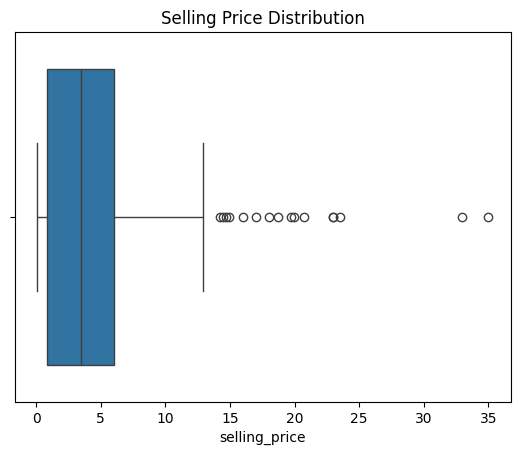

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot for selling price
sns.boxplot(x=df['selling_price'])
plt.title("Selling Price Distribution")
plt.show()

# Remove expensive price outliers
df = df[df['selling_price'] < df['selling_price'].quantile(0.99)]

# Remove high mileage outliers
df = df[df['driven_kms'] < df['driven_kms'].quantile(0.99)]


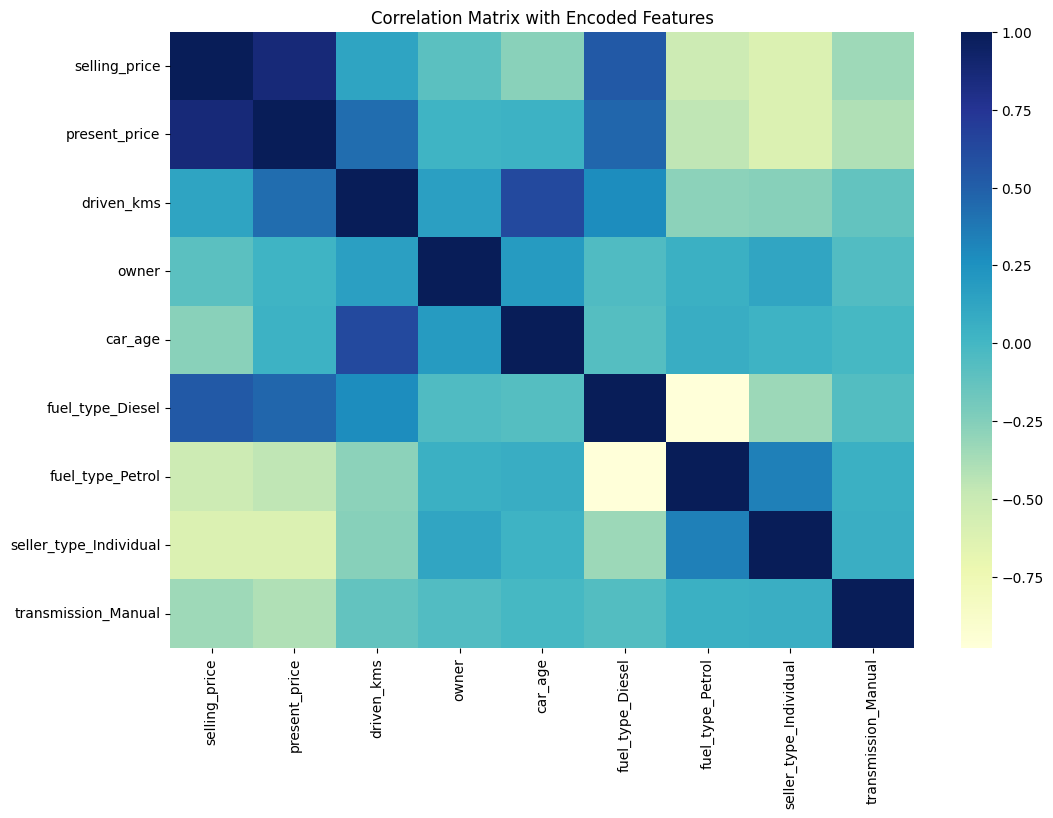

In [36]:
# Temporarily encode categorical features
encoded_df = df.copy()

# One-hot encode all object (string) columns
encoded_df = pd.get_dummies(encoded_df, drop_first=True)

# Now compute correlation
plt.figure(figsize=(12, 8))
sns.heatmap(encoded_df.corr(), cmap="YlGnBu", annot=False)
plt.title("Correlation Matrix with Encoded Features")
plt.show()


In [37]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Define categorical and numerical features
cat_cols = ['fuel_type', 'seller_type', 'transmission']
num_cols = ['present_price', 'driven_kms', 'owner', 'car_age']

# Tell encoder to ignore unknown categories
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])


In [38]:
# Define model pipelines
models = {
    "Linear Regression": Pipeline([("pre", preprocessor), ("model", LinearRegression())]),
    "Ridge Regression": Pipeline([("pre", preprocessor), ("model", Ridge(alpha=1.0))]),
    "Random Forest": Pipeline([("pre", preprocessor), ("model", RandomForestRegressor(n_estimators=100, random_state=42))]),
    "Gradient Boosting": Pipeline([("pre", preprocessor), ("model", GradientBoostingRegressor(n_estimators=100))])
}


In [39]:
X = df.drop(columns=['selling_price'])
y = df['selling_price']


In [40]:
for name, pipe in models.items():
    pipe.fit(X, y)
    scores = cross_val_score(pipe, X, y, cv=5, scoring='r2')
    print(f"{name}: R² mean = {scores.mean():.3f}, std = {scores.std():.3f}")


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Linear Regression: R² mean = -14.957, std = 31.524
Ridge Regression: R² mean = -15.048, std = 31.707


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Random Forest: R² mean = 0.115, std = 1.481


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Gradient Boosting: R² mean = 0.221, std = 1.307


In [41]:
param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_split": [2, 5],
}

grid = GridSearchCV(
    Pipeline([("pre", preprocessor), ("model", RandomForestRegressor(random_state=42))]),
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)

grid.fit(X, y)
print("Best parameters:", grid.best_params_)
print("Best R² score:", grid.best_score_)


Best parameters: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best R² score: -0.0802952701648612


MAE: 0.329277613803334
RMSE: 0.5783228009751845
R²: 0.9872647536839239


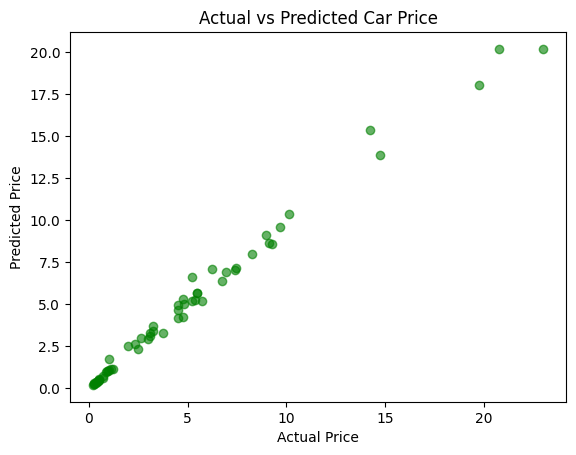

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

# Visualize
plt.scatter(y_test, y_pred, alpha=0.6, color='green')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Price")
plt.show()


In [43]:
joblib.dump(best_model, "car_price_advanced_model.pkl")
print("Model saved as car_price_advanced_model.pkl")


Model saved as car_price_advanced_model.pkl
